# Rethinking Confidence Calibration for Failure Prediction
The paper "Rethinking Confidence Calibration for Failure Prediction" explores the concepts of confidence calibration and failure prediction in the context of deep neural networks (DNNs).

In [1]:
pip install torch torchvision

In [2]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.9 MB/s eta 0:00:00


In [3]:
!pip install matplotlib

In [4]:

from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/pytorch'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))

Mounted at /content/gdrive
['Bayesian.ipynb', 'CRL_moon.ipynb', 'CRL_moon_cifar.ipynb', 'Cifar_baseline.ipynb', 'DAC+Dropout_incomplete.ipynb', 'DAC+Temp.ipynb', 'DAC+Temp_Cifar.ipynb', 'DAC+Temp_Cifar_dropout_swin.ipynb', 'DAC+Temp_Cifar_mixup_labelsmoothing_swin.ipynb', 'DAC+Temp_Cifar_swin.ipynb', 'Dropout.ipynb', 'Dropout_cifar.ipynb', 'FocalLoss.ipynb', 'FocalLoss_cifar.ipynb', 'LabelSmoothing.ipynb', 'LabelSmoothing_cifar.ipynb', 'Mixup.ipynb', 'Mixup_cifar.ipynb', 'ResNet.ipynb', '__init__.py', '__pycache__', 'baseline.ipynb', 'data', 'model', 'py_code', 'result_auroc_OD.json', 'result_auroc_OD_CRL.json', 'result_auroc_OD_LS.json', 'result_auroc_OD_baseline.json', 'result_auroc_OD_dropout.json', 'result_auroc_OD_mixup.json', 'results_DAC_temp.json', 'results_DAC_temp_cifar.json', 'results_DAC_temp_swin.json', 'results_Dropout.json', 'results_Dropout_swin.json', 'results_ECE.json', 'results_ECE_CRL.json', 'results_ECE_LS.json', 'results_ECE_LS_cifar.json', 'results_ECE_OD.json', 

In [5]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, TensorDataset,Dataset
import torchvision.models as models
import torch
from torchvision.transforms import ToPILImage
import numpy as np
import random
from PIL import Image


model = models.resnet50(pretrained=True) #pretrained on imagenet which have 1000 images
num_features = model.fc.in_features  # Get the input features of the final fully connected layer
model.fc = torch.nn.Linear(num_features, 10)  # Replace it with a new fully connected layer with 10 outputs


# Custom Dataset class to load images on-the-fly
class CIFARC_Dataset(Dataset):
    def __init__(self, data: np.ndarray, labels: list, transform=None):
        assert len(data) == len(labels)
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # CIFAR images are in the format (channels, height, width)
        # We need to convert them to (height, width, channels) for PIL
        img = self.data[idx].transpose((1, 2, 0))  # Convert to HxWxC
        img = Image.fromarray(img.astype('uint8'), 'RGB')  # Convert to PIL Image
        label = self.labels[idx]

        label = torch.tensor(label, dtype=torch.long)

        if self.transform is not None:
            img = self.transform(img)

        return img, label

class CombinedCIFARCDataset(Dataset):
    def __init__(self, datasets):
        self.datasets = datasets
        self.lengths = [len(d) for d in datasets]
        self.cumulative_lengths = np.cumsum(self.lengths)

    def __len__(self):
        return sum(self.lengths)

    def __getitem__(self, idx):
        if idx < 0 or idx >= self.__len__():
            raise IndexError(f"Index out of range: {idx}")

        # Determine which dataset the index falls into
        dataset_idx = np.searchsorted(self.cumulative_lengths, idx, side='right')
        if dataset_idx > 0:
            relative_idx = idx - self.cumulative_lengths[dataset_idx - 1]
        else:
            relative_idx = idx

        return self.datasets[dataset_idx][relative_idx]


# Transformations for the images
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
full_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Get the labels from the CIFAR-10 test set
test_labels = full_test_dataset.targets

# Load CIFAR-10-C dataset
file_path = './data/CIFAR-10-C/zoom_blur.npy'  # Make sure this path is correct
cifar_c_data_blur = np.load(file_path)
cifar_c_data_blur = cifar_c_data_blur.transpose((0, 3, 1, 2))  # Reorder dimensions to match PyTorch's (batch_size, channels, height, width)

# Create an instance of the CIFARC_Dataset with the first 500 images and corresponding labels
cifar_c_dataset_blur = CIFARC_Dataset(data=cifar_c_data_blur[:500], labels=test_labels[:500], transform=transform)


file_path = './data/CIFAR-10-C/speckle_noise.npy'  # Make sure this path is correct
cifar_c_data_speckle = np.load(file_path)
cifar_c_data_speckle = cifar_c_data_speckle.transpose((0, 3, 1, 2))  # Reorder dimensions to match PyTorch's (batch_size, channels, height, width)

# Create an instance of the CIFARC_Dataset with the first 500 images and corresponding labels
cifar_c_dataset_speckle = CIFARC_Dataset(data=cifar_c_data_speckle[:500], labels=test_labels[:500], transform=transform)
# Instantiate the Combined Dataset with blur and speckle datasets
combined_cifar_c_dataset = CombinedCIFARCDataset([cifar_c_dataset_blur, cifar_c_dataset_speckle])
# Define DataLoaders for the datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_subset, test_subset = random_split(full_test_dataset, [len(full_test_dataset) // 2, len(full_test_dataset) - len(full_test_dataset) // 2])
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False, num_workers=2)
# Define a DataLoader for the combined dataset
OD_loader = DataLoader(combined_cifar_c_dataset, batch_size=64, shuffle=False, num_workers=2)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s]


Files already downloaded and verified
Files already downloaded and verified


All models are trained using SGD with a momentum
of 0.9, an initial learning rate of 0.1, and a weight decay of 5e-4 for 200 epochs
with the mini-batch size of 128 on CIFAR-10 and CIFAR-100. The learning rate is
reduced by a factor of 10 at 80, 130, and 170 epochs. We randomly sample 10% of
training samples as a validation dataset for each task because it is a requirement
for post-calibration methods like temperature scaling [15]. For each experiment,
the mean and standard deviation over three random runs are reported

For public pretrained ResNet50 model initialization

For the model used in the paper

In [6]:
# from model import LeNet
# from model import AlexNet
# from model import resnet
# from model import resnet18
# from model import densenet_BC
# from model import vgg
# from model import mobilenet
# from model import efficientnet
# from model import wrn
# from model import convmixer

# num_cls
# model_dict = {
#         "num_classes": num_class,
#     }
# model = resnet.resnet110(**model_dict).cuda()

# #other possible model initialization
# model = resnet18.ResNet18(**model_dict).cuda()
# model = vgg.vgg16(**model_dict).cuda()

In [7]:
pip install tqdm tensorboard

AD hoc: Mixup
Mixup creates new training examples by linearly combining inputs and their labels, which can improve model generalization.
Mixup is a data augmentation technique that improves model generalization and robustness by creating virtual training examples. Here's how it works and why it can improve model confidence:

How Mixup Works:

Mixup generates new training samples by linearly combining pairs of inputs and their labels.
Given two input samples x i ,x j and their labels y i ,y j , mixup creates a new sample mixed x mixedand label mixed y mixed as follows: mixed=+(1−)x mixed
​ =λxi​ +(1−λ)xj​ mixed=+(1−)y mixed =λyi​ +(1−λ)yj​
The mixing coefficient λ is typically drawn from a Beta distribution, e.g., Beta(,α,α), where
α is a hyperparameter.
Improving Model Confidence:

Enhanced Generalization: By training on these blended examples, the model learns to interpolate between classes, leading to better generalization.
Smooth Decision Boundaries: Mixup encourages the model to predict less confidently on points that are linear combinations of inputs from different classes, which can result in smoother decision boundaries.
Robustness to Label Noise: Since mixup combines labels, it can make the model more robust to noisy labels, reducing overfitting to incorrect labels.
Better Uncertainty Estimation: Models trained with mixup often provide better-calibrated probabilities, reflecting more accurate uncertainty in predictions.

In [8]:
import torch
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
def mixup_data(x, y, alpha=0.3, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

train_losses = []
val_accuracies = []

# Updated Parameters
num_epochs = 30  # can stop it earlier if no obvious increase in the model accuracy for saving time
learning_rate = 0.01
momentum = 0.9
weight_decay = 5e-4
batch_size = 64  # Ensure your DataLoader uses this batch size, in the paper they used 128

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for inputs, labels in tqdm(train_loader):  # Ensure your DataLoader is defined with the correct batch_size
        inputs, labels = inputs.to(device), labels.to(device)

        # Apply mixup
        mixed_inputs, targets_a, targets_b, lam = mixup_data(inputs, labels)
        outputs = model(mixed_inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {avg_loss:.4f} - Val Accuracy: {val_accuracy:.2f}%")

print("Finished Training")


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 1/30] Loss: 0.9154 - Val Accuracy: 93.22%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 2/30] Loss: 0.6857 - Val Accuracy: 94.40%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 3/30] Loss: 0.6408 - Val Accuracy: 94.34%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 4/30] Loss: 0.6311 - Val Accuracy: 93.52%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 5/30] Loss: 0.5904 - Val Accuracy: 94.36%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 6/30] Loss: 0.5538 - Val Accuracy: 95.06%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 7/30] Loss: 0.5691 - Val Accuracy: 94.40%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 8/30] Loss: 0.5864 - Val Accuracy: 94.54%


  0%|          | 0/782 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

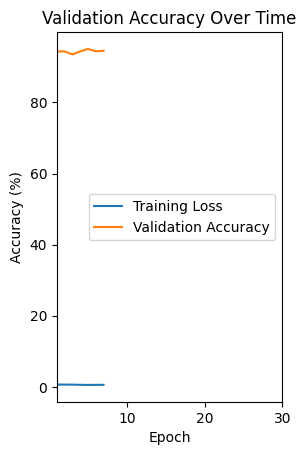

In [10]:
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.xlim(1, num_epochs)  # Set x-axis limits

# Plot validation accuracy
plt.subplot(1, 2, 1)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Time')
plt.legend()
plt.xlim(1, num_epochs)  # Set x-axis limits

plt.show()


In [11]:
def evaluate(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    # We'll also keep track of the loss for the test dataset
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = outputs.max(1)  # Predicted class is the max index across the softmax probabilities
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader)

    return accuracy, avg_test_loss

# To use the evaluate function:
accuracy, avg_loss = evaluate(model,test_loader, device) # change the data here to experience concept drift
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Average Test Loss: {avg_loss:.4f}")

Test Accuracy: 94.00%
Average Test Loss: 0.2550


In [12]:
def evaluate(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    # We'll also keep track of the loss for the test dataset
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = outputs.max(1)  # Predicted class is the max index across the softmax probabilities
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader)

    return accuracy, avg_test_loss

# To use the evaluate function:
accuracy, avg_loss = evaluate(model,test_loader, device) # change the data here to experience concept drift, for cifar, the test data is the OD data
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Average Test Loss: {avg_loss:.4f}")

Test Accuracy: 94.00%
Average Test Loss: 0.2550


In [13]:
import torch.nn.functional as F
def compute_ece(probs, labels, n_bins=10):
    """
    Compute the Expected Calibration Error (ECE).

    Args:
        probs: Tensor of predicted probabilities of shape [N, C] where C is number of classes.
        labels: Tensor of true labels of shape [N].
        n_bins: Number of bins to use for ECE computation.

    Returns:
        ece: Expected Calibration Error.
    """

    # Get the predicted confidence values (maximum predicted probability)
    confidences, predictions = probs.max(1)

    # Initialize lists to store true positive counts and total count for each bin
    bin_true_positives = [0 for _ in range(n_bins)]
    bin_total = [0 for _ in range(n_bins)]

    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    for bin_idx in range(n_bins):
        # Indices of items in the current bin777
        bin_indices = (confidences > bin_lowers[bin_idx]) & (confidences <= bin_uppers[bin_idx])

        bin_true_positives[bin_idx] += (predictions[bin_indices] == labels[bin_indices]).float().sum().item()
        bin_total[bin_idx] += bin_indices.float().sum().item()

    # Compute bin accuracies and average confidences
    bin_accuracies = [bin_true_positives[i] / bin_total[i] if bin_total[i] > 0 else 0 for i in range(n_bins)]
    bin_avg_confidences = [torch.sum(confidences[(confidences > bin_lowers[i]) & (confidences <= bin_uppers[i])]).item() / bin_total[i] if bin_total[i] > 0 else 0 for i in range(n_bins)]

    ece = sum([bin_total[i] / float(probs.size(0)) * abs(bin_avg_confidences[i] - bin_accuracies[i]) for i in range(n_bins)])

    return ece

# After your training/testing loops
# initialization for porbs and truelabels
probs = torch.tensor([]).to(device)
true_labels = torch.tensor([]).to(device)

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Ensure that outputs is a 2D tensor
        if outputs.ndim == 1:
            outputs = outputs.unsqueeze(0)  # Add batch dimension if missing
        if outputs.ndim != 2:
            raise ValueError("Output from the model must be a 2D tensor")

        actual_outputs = outputs  # Assuming outputs is already the logits

        # Apply softmax on the correct dimension
        output_probs = F.softmax(actual_outputs, dim=1)
        probs = torch.cat([probs, output_probs], dim=0)
        true_labels = torch.cat([true_labels, labels], dim=0)

ece = compute_ece(probs, true_labels)
print(f"Expected Calibration Error (ECE): {ece:.4f}")



Expected Calibration Error (ECE): 0.0699


In [14]:
# Sample test result and current datetime
import json
from datetime import datetime
result_ece = {
    "datetime": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "ECE": ece  # Example accuracy value
}

# Saving the result to 'results.json'
with open('results_ECE_mixup_cifar.json', 'a') as file:
    file.write(json.dumps(result_ece) + '\n')


In [15]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import torch.nn.functional as F

model.eval()
n_classes = 10  # Number of classes
correctness = []
predicted_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Extract the actual output logits from the tuple
        logits = outputs[0] if isinstance(outputs, tuple) else outputs

        # Get probabilities for all classes
        probs = F.softmax(logits, dim=1)

        # Store probabilities
        predicted_probs.extend(probs.cpu().numpy())

        # Convert labels to one-hot encoding
        labels_one_hot = label_binarize(labels.cpu().numpy(), classes=range(n_classes))
        correctness.extend(labels_one_hot)

# Convert lists to numpy arrays
correctness = np.array(correctness)
predicted_probs = np.array(predicted_probs)

# Calculate ROC AUC for each class and average
auroc = [roc_auc_score(correctness[:, i], predicted_probs[:, i]) for i in range(n_classes)]
average_auroc = np.mean(auroc)
print(f"Average AUROC: {average_auroc:.4f}")

Average AUROC: 0.9975


In [16]:
# Sample test result and current datetime
result_auroc = {
    "datetime": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "auroc": auroc  # Example accuracy value
}

# Saving the result to 'results.json'
with open('results_auroc_mixup_cifar.json', 'a') as file:
    file.write(json.dumps(result_auroc) + '\n')
    # bear in mind that the above 2 code blocks are for the ID acc and ECE, the below blocks are for the OD

The Above code are all for the ID dada,
Below are for the OD data for calculating the ECE for data with concept drift

In [17]:
import torch.nn.functional as F
# After your training/testing loops
probs = torch.tensor([]).to(device)
true_labels = torch.tensor([]).to(device)
model = model.to(device)

model.eval()
with torch.no_grad():
    for inputs, labels in OD_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Ensure that outputs is a 2D tensor
        if outputs.ndim == 1:
            outputs = outputs.unsqueeze(0)  # Add batch dimension if missing
        if outputs.ndim != 2:
            raise ValueError("Output from the model must be a 2D tensor")

        actual_outputs = outputs  # Assuming outputs is already the logits

        # Apply softmax on the correct dimension
        output_probs = F.softmax(actual_outputs, dim=1)
        probs = torch.cat([probs, output_probs], dim=0)
        true_labels = torch.cat([true_labels, labels], dim=0)


ece_od = compute_ece(probs, true_labels)
print(f"Expected Calibration Error (ECE): {ece_od:.4f}")

Expected Calibration Error (ECE): 0.0960


In [19]:
# Sample test result and current datetime
result_ece_od = {
    "datetime": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "ECE": ece_od  # Example accuracy value
}

# Saving the result to 'results.json'
with open('results_ECE_OD_mixup_cifar.json', 'a') as file:
    file.write(json.dumps(result_ece_od) + '\n')